This notebook provides аn example of an algorithm for producing continuous futures data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
underlying = 'NQ'
contracts = ['M0', 'U0', 'Z0', 'H1', 'M1', 'U1', 'Z1']

In [3]:
def daily_volumes(ticker):
    """
    Reading data and daily volumes calculation
    """
    # You need to insert the path to the data file
    candles = pd.read_csv(ticker +'.csv', sep = ';')
    #All datasets for this course are available at this link:
    #https://drive.google.com/drive/folders/1mhbVjuwNZGX9nmZuCxJStBmraF3HIzio?usp=sharing

    candles['timestamp'] = pd.to_datetime(candles['timestamp'], format = "%Y-%m-%dT%H:%M:%SZ")
    candles = candles.set_index('timestamp')

    candles = candles[~candles.index.duplicated(keep='first')]
    candles = candles.sort_index()

    daily_candles = candles[['volume']]
    daily_candles = daily_candles.resample('1D').sum()
    return candles, daily_candles

In [4]:
candles = pd.read_csv('NQH1.csv', sep = ';')
candles['timestamp'] = pd.to_datetime(candles['timestamp'], format = "%Y-%m-%dT%H:%M:%SZ")
candles = candles.set_index('timestamp')

candles = candles[~candles.index.duplicated(keep='first')]
candles = candles.sort_index()
candles

open      high       low     close  volume
timestamp                                                          
2020-10-20 01:01:00  11702.25  11702.25  11701.00  11701.00     3.0
2020-10-20 01:19:00  11711.75  11711.75  11711.75  11711.75     1.0
2020-10-20 01:28:00  11692.00  11692.00  11679.75  11679.75     2.0
2020-10-20 01:32:00  11670.50  11670.50  11668.00  11668.00     2.0
2020-10-20 01:37:00  11673.50  11673.50  11672.00  11672.00     3.0
...                       ...       ...       ...       ...     ...
2021-03-18 23:55:00  12806.00  12806.25  12806.00  12806.25     2.0
2021-03-18 23:56:00  12803.00  12803.00  12800.50  12802.25     3.0
2021-03-18 23:58:00  12800.25  12804.25  12800.00  12804.25     4.0
2021-03-18 23:59:00  12799.25  12800.25  12799.25  12799.25     3.0
2021-03-19 00:00:00  12800.25  12800.25  12797.50  12797.50    23.0

[104002 rows x 5 columns]

In [5]:
daily_candles = candles[['volume']]
daily_candles = daily_candles.resample('1D').sum()
daily_candles

volume
timestamp           
2020-10-20     581.0
2020-10-21     380.0
2020-10-22     334.0
2020-10-23     280.0
2020-10-24       0.0
...              ...
2021-03-15  216608.0
2021-03-16  174964.0
2021-03-17  138560.0
2021-03-18   72125.0
2021-03-19      23.0

[151 rows x 1 columns]

Algorithm for making a continuous futures from data for the original individual contracts:

   2020-06-14 00:00:00
2020-06-14 00:00:00
   2020-09-13 00:00:00
2020-09-13 00:00:00
   2020-12-13 00:00:00
2020-12-13 00:00:00
   2021-03-14 00:00:00
2021-03-14 00:00:00
   2021-06-13 00:00:00
2021-06-13 00:00:00
   2021-09-12 00:00:00
2021-09-12 00:00:00


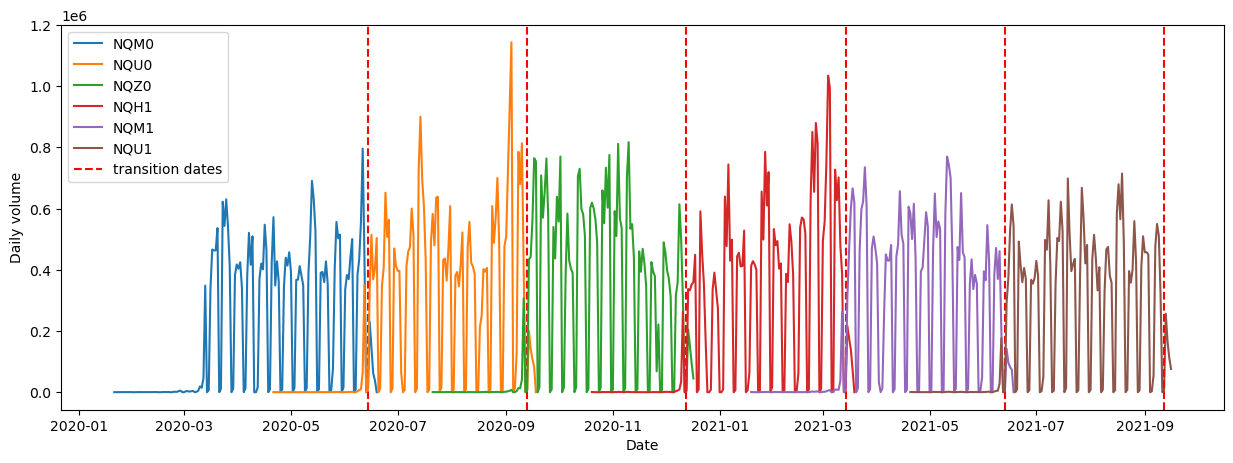

In [6]:
candles = pd.DataFrame()
plt.figure(figsize = (15, 5))
futures_merge_dates = []

for i in np.arange(len(contracts)-1):
    ticker1 = underlying + contracts[i]
    ticker2 = underlying + contracts[i+1]

    candles1, daily_candles1 = daily_volumes(ticker1)
    candles2, daily_candles2 = daily_volumes(ticker2)

    plt.plot(daily_candles1.index, daily_candles1['volume'], label=ticker1)

    if candles.shape[0] == 0:
        candles = candles1

    # We calculate sum and diff over the entire time period, but not at any given time both futures exist
    # Therefore we do merge 'outer' and fill NaN as 0, because at that moment the futures are not traded
    vols = daily_candles1.merge(daily_candles2, how = 'outer', left_index = True, right_index = True).fillna(0)
    vols['diff'] = vols['volume_y']-vols['volume_x']
    vols['sum'] = vols['volume_y']+vols['volume_x']

    # The first part of the logical expression is responsible for detecting the moments in time when trading on both futures becomes small
    # At this moment, nothing needs to be done, it could be a weekend or something else, but not necessarily a transition of volumes
    # The second part of the expression is responsible for detecting the transition of volumes from one futures to another
    # the graph will be presented below
    vols['check'] = (vols['sum']<vols['sum'].ewm(10).mean())*(vols['diff']>0)

    futures_merge_date = vols.index[vols['check'] == True][0]
    print("  ",futures_merge_date)

    if i == len(contracts) - 2:
        plt.axvline(futures_merge_date, color = 'red', linestyle='--', label='transition dates')
    else:
        plt.axvline(futures_merge_date, color = 'red', linestyle='--')

    candles = pd.concat([candles[:futures_merge_date], candles2[futures_merge_date:]])
    print(futures_merge_date)
    futures_merge_dates.append(futures_merge_date)

candles = candles[~candles.index.duplicated(keep='first')]
candles = candles.sort_index()

plt.ylabel('Daily volume')
plt.xlabel('Date')
plt.legend()
plt.show()

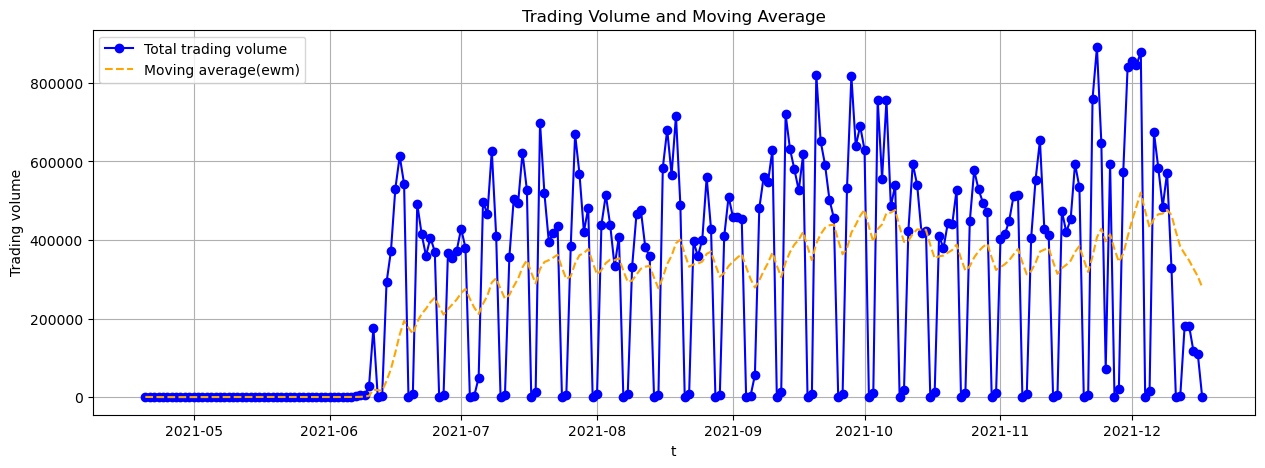

In [7]:
# Plotting graphs
ticker1 = underlying + contracts[5]
ticker2 = underlying + contracts[6]

candles1, daily_candles1 = daily_volumes(ticker1)
candles2, daily_candles2 = daily_volumes(ticker2)

# The first part of the logical expression is responsible for detecting the moments in time when trading on both futures becomes small
# At this moment, nothing needs to be done, it could be a weekend or something else, but not necessarily a transition of volumes
# The second part of the expression is responsible for detecting the transition of volumes from one futures to another
# the graph will be presented below
vols = daily_candles1.merge(daily_candles2, how = 'outer', left_index = True, right_index = True).fillna(0)
vols['diff'] = vols['volume_y']-vols['volume_x']
vols['sum'] = vols['volume_y']+vols['volume_x']

plt.figure(figsize=(15, 5))
plt.plot(vols.index, vols['sum'], label='Total trading volume', color='blue', marker='o')
plt.plot(vols.index, vols['sum'].ewm(10).mean(), label='Moving average(ewm)', color='orange', linestyle='--')

# Setting up the graph
plt.title('Trading Volume and Moving Average')
plt.xlabel('t')
plt.ylabel('Trading volume')
plt.legend()
plt.grid()

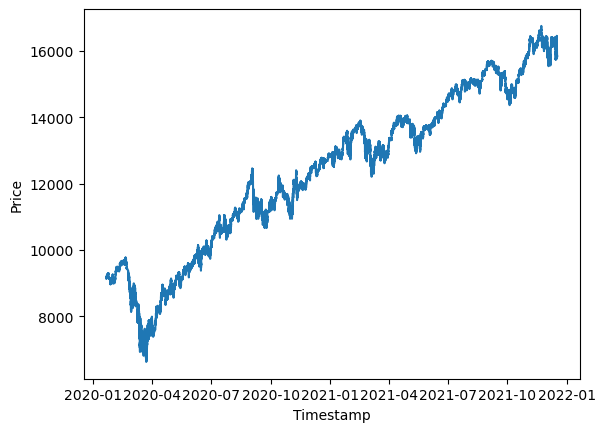

In [8]:
plt.plot(candles['close'])
plt.ylabel('Price')
_ = plt.xlabel('Timestamp')

Additional exercises and research topics:

1. Explore different methods of financial data aggregation in terms of information transfer, augmentation potential, and usefulness for developing algorithmic strategies

In [9]:
def time_bars(df, freq='5T'):
    """
    Aggregates tick or minute data into time bars.
    'freq' can be '1T', '5T', '1H', etc.
    """
    return df.resample(freq).sum().dropna()


In [46]:
def time_bars(df, freq='5T'):
    """
    Aggregates tick or minute data into time bars.
    Includes open, high, low, close, volume, start_time, end_time.
    'freq' can be '1T', '5T', '1H', etc.
    Assumes datetime index.
    """
    ohlc_dict = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }

    resampled = df.resample(freq).agg(ohlc_dict).dropna()

    resampled['start_time'] = resampled.index
    resampled['end_time'] = resampled.index + pd.to_timedelta(freq)

    return resampled.reset_index(drop=True)

In [56]:
def volume_bars(df, threshold=50000):
    """
    Aggregates rows into bars where cumulative volume >= threshold.
    """
    bars = []
    bar = []
    cum_vol = 0

    for _, row in df.iterrows():
        bar.append(row)
        cum_vol += row['volume']
        if cum_vol >= threshold:
            bar_df = pd.DataFrame(bar)
            bars.append({
                'open': bar_df.iloc[0]['open'],
                'high': bar_df['high'].max(),
                'low': bar_df['low'].min(),
                'close': bar_df.iloc[-1]['close'],
                'volume': bar_df['volume'].sum(),
                'start_time': bar_df.index[0],
                'end_time': bar_df.index[-1]
            })
            bar = []
            cum_vol = 0

    return pd.DataFrame(bars)


In [57]:
def dollar_bars(df, dollar_threshold=10000000):
    """
    Aggregates rows into bars where close * volume >= dollar_threshold.
    """
    bars = []
    bar = []
    cum_dollars = 0

    for _, row in df.iterrows():
        dollar_val = row['close'] * row['volume']
        bar.append(row)
        cum_dollars += dollar_val
        if cum_dollars >= dollar_threshold:
            bar_df = pd.DataFrame(bar)
            bars.append({
                'open': bar_df.iloc[0]['open'],
                'high': bar_df['high'].max(),
                'low': bar_df['low'].min(),
                'close': bar_df.iloc[-1]['close'],
                'volume': bar_df['volume'].sum(),
                'dollar_value': (bar_df['close'] * bar_df['volume']).sum(),
                'start_time': bar_df.index[0],
                'end_time': bar_df.index[-1]
            })
            bar = []
            cum_dollars = 0

    return pd.DataFrame(bars)


In [58]:
df_time_bars = time_bars(candles, '1H')
df_time_bars

open      high       low     close  volume          start_time  \
0     11702.25  11711.75  11665.50  11673.50    21.0 2020-10-20 01:00:00   
1     11698.00  11698.25  11677.00  11677.00     7.0 2020-10-20 02:00:00   
2     11691.50  11721.50  11683.50  11714.25    12.0 2020-10-20 03:00:00   
3     11690.00  11703.50  11689.00  11696.00     9.0 2020-10-20 04:00:00   
4     11690.00  11716.00  11677.75  11715.75    18.0 2020-10-20 05:00:00   
...        ...       ...       ...       ...     ...                 ...   
2393  12861.00  12876.00  12777.50  12797.25  7529.0 2021-03-18 19:00:00   
2394  12796.75  12840.25  12789.25  12807.50  1404.0 2021-03-18 20:00:00   
2395  12818.25  12837.00  12798.50  12802.00   248.0 2021-03-18 22:00:00   
2396  12802.00  12811.75  12791.25  12799.25   168.0 2021-03-18 23:00:00   
2397  12800.25  12800.25  12797.50  12797.50    23.0 2021-03-19 00:00:00   

                end_time  
0    2020-10-20 02:00:00  
1    2020-10-20 03:00:00  
2    2020-10-20 04:00:00  
3    2020-10-20 05:00:00  
4    2020-10-20 06:00:00  
...                  ...  
2393 2021-03-18 20:00:00  
2394 2021-03-18 21:00:00  
2395 2021-03-18 23:00:00  
2396 2021-03-19 00:00:00  
2397 2021-03-19 01:00:00  

[2398 rows x 7 columns]

In [59]:

df_volumn_bars = volume_bars(candles)
df_volumn_bars

open      high       low     close   volume          start_time  \
0    11702.25  12667.75  10936.25  12300.75  50105.0 2020-10-20 01:01:00   
1    12302.25  12447.75  12262.50  12326.75  50016.0 2020-12-10 14:40:00   
2    12327.00  12353.75  12273.75  12327.50  50564.0 2020-12-11 14:19:00   
3    12327.50  12358.50  12263.50  12279.25  50480.0 2020-12-11 15:09:00   
4    12279.00  12302.00  12233.75  12301.00  50110.0 2020-12-11 16:43:00   
..        ...       ...       ...       ...      ...                 ...   
649  13280.00  13292.25  13150.75  13161.00  50268.0 2021-03-16 15:11:00   
650  13160.50  13198.00  13087.00  13135.75  50017.0 2021-03-16 18:09:00   
651  13135.75  13139.00  12946.50  13019.50  50435.0 2021-03-17 08:59:00   
652  13019.25  13236.75  12951.75  13234.25  50219.0 2021-03-17 14:52:00   
653  13232.00  13283.25  12960.00  13004.25  50441.0 2021-03-17 18:45:00   

               end_time  
0   2020-12-10 14:39:00  
1   2020-12-11 14:18:00  
2   2020-12-11 15:08:00  
3   2020-12-11 16:42:00  
4   2020-12-11 18:12:00  
..                  ...  
649 2021-03-16 18:08:00  
650 2021-03-17 08:58:00  
651 2021-03-17 14:51:00  
652 2021-03-17 18:44:00  
653 2021-03-18 13:40:00  

[654 rows x 7 columns]

In [60]:
df_dollars_bars = dollar_bars(candles)
df_dollars_bars

open      high       low     close  volume  dollar_value  \
0      11702.25  11777.00  11588.00  11739.00   857.0   10015544.75   
1      11736.00  11742.00  11506.00  11607.00   862.0   10013940.50   
2      11605.00  11676.00  11343.75  11574.00   869.0   10007616.00   
3      11583.00  11613.00  11122.75  11401.00   886.0   10008051.25   
4      11407.25  11424.00  10936.25  11114.00   903.0   10014943.50   
...         ...       ...       ...       ...     ...           ...   
26166  12798.25  12807.50  12785.50  12799.00  1069.0   13679297.50   
26167  12799.00  12811.25  12798.25  12803.25   824.0   10550493.00   
26168  12803.50  12808.00  12789.50  12797.25  1340.0   17150896.00   
26169  12796.75  12840.25  12789.25  12833.25   792.0   10144112.75   
26170  12834.50  12837.00  12803.75  12809.50   788.0   10101543.50   

               start_time            end_time  
0     2020-10-20 01:01:00 2020-10-21 18:56:00  
1     2020-10-21 18:57:00 2020-10-26 13:33:00  
2     2020-10-26 13:34:00 2020-10-27 19:28:00  
3     2020-10-27 19:30:00 2020-10-29 19:29:00  
4     2020-10-29 19:30:00 2020-11-02 12:53:00  
...                   ...                 ...  
26166 2021-03-18 19:52:00 2021-03-18 19:55:00  
26167 2021-03-18 19:56:00 2021-03-18 19:57:00  
26168 2021-03-18 19:58:00 2021-03-18 19:59:00  
26169 2021-03-18 20:00:00 2021-03-18 20:07:00  
26170 2021-03-18 20:08:00 2021-03-18 22:27:00  

[26171 rows x 8 columns]

In [61]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import pandas as pd

def plot_time_bars(df):
    df = df.tail(100)  # Last 500 bars

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()

    # Ensure datetime
    df['end_time'] = pd.to_datetime(df['end_time'])

    # Convert to matplotlib date float
    df['mdates'] = mdates.date2num(df['end_time'])

    # Width in days
    candle_width = 0.02  # ~30 min width

    for _, row in df.iterrows():
        color = 'green' if row['close'] >= row['open'] else 'red'
        lower = min(row['open'], row['close'])
        height = abs(row['close'] - row['open'])

        # Candle body
        ax1.add_patch(Rectangle((row['mdates'], lower), candle_width, height,
                                color=color, alpha=0.8))

        # Wick
        ax1.vlines(row['mdates'], row['low'], row['high'], color=color, linewidth=1)

    # Volume
    ax2.bar(df['mdates'], df['volume'], width=candle_width, color='gray', alpha=0.3)

    ax1.set_title('Time Bar Candlestick (Last 500)')
    ax1.set_ylabel('Price')
    ax2.set_ylabel('Volume')

    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    fig.autofmt_xdate()

    ax1.grid(True)
    plt.tight_layout()
    plt.show()




def plot_volume_bars(df):
    df = df.tail(500)  # Keep only the last 500 points
    plt.figure(figsize=(12, 6))

    # Plot closing price as a line
    plt.plot(df['end_time'], df['close'], label='Close Price', color='blue')

    # Plot volume as bar chart (secondary axis)
    plt.twinx()
    plt.bar(df['end_time'], df['volume'], width=0.005, alpha=0.3, color='gray', label='Volume')

    plt.title('Volume Bar Aggregation')
    plt.xlabel('Time')
    plt.ylabel('Volume')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_dollar_bars(df):
    df = df.tail(500)  # Keep only the last 500 points
    plt.figure(figsize=(12, 6))

    # Price line
    plt.plot(df['end_time'], df['close'], label='Close Price', color='green')

    # Dollar value bar chart
    plt.twinx()
    plt.bar(df['end_time'], df['dollar_value'], width=0.005, alpha=0.3, color='orange', label='Dollar Value')

    plt.title('Dollar Bar Aggregation')
    plt.xlabel('Time')
    plt.ylabel('Dollar Traded')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


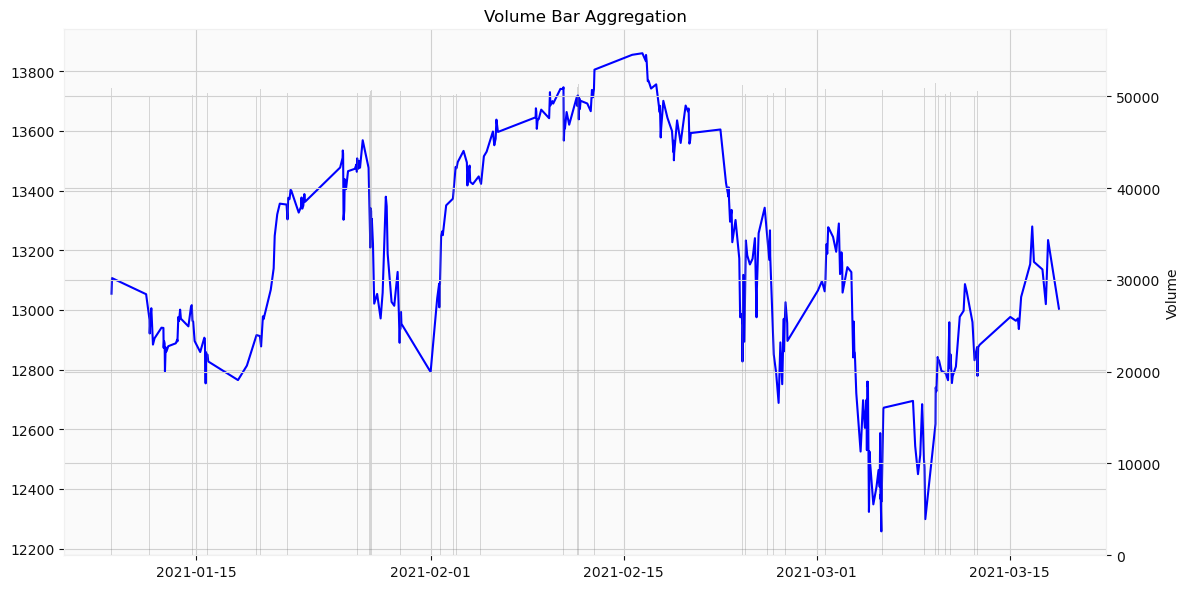

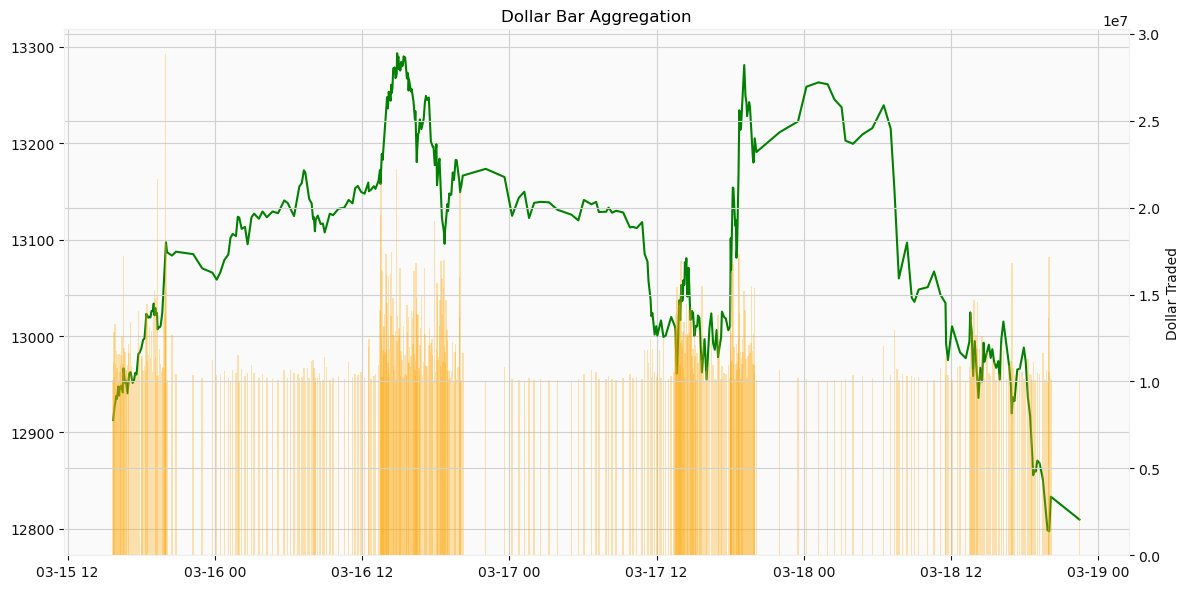

/var/folders/jb/2p1d0r8172d41n4v68yjbqym0000gn/T/ipykernel_46943/3130825029.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])
/var/folders/jb/2p1d0r8172d41n4v68yjbqym0000gn/T/ipykernel_46943/3130825029.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mdates'] = mdates.date2num(df['end_time'])


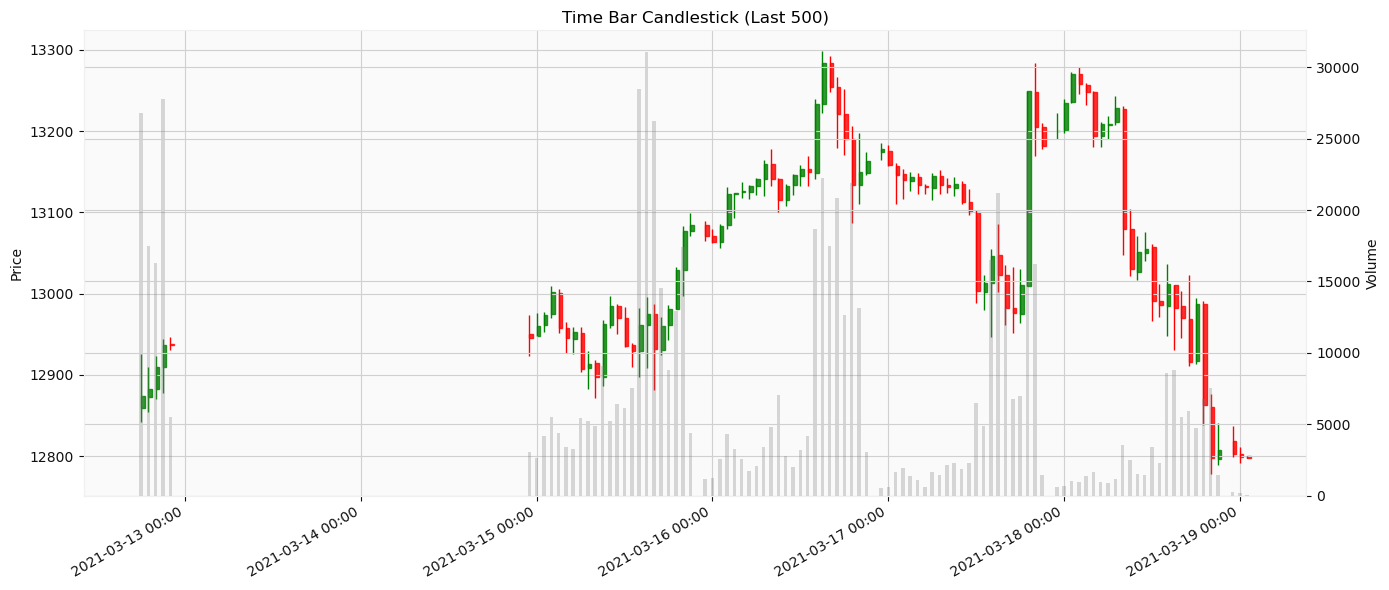

In [62]:

plot_volume_bars(df_volumn_bars)
plot_dollar_bars(df_dollars_bars)
plot_time_bars(df_time_bars)


In [39]:
import mplfinance as mpf

def plot_candles(df, title="Candlestick Chart"):
    df = df.tail(800)  # Keep only the last 500 points
    # Make sure timestamp is datetime and index
    df = df.copy()
    df['end_time'] = pd.to_datetime(df['end_time'])
    df.set_index('end_time', inplace=True)

    df = df.tail(500)  # Limit to last 500 bars for clarity

    ohlc_df = df[['open', 'high', 'low', 'close', 'volume']]
    
    mpf.plot(ohlc_df, type='candle', volume=True, style='yahoo', title=title)


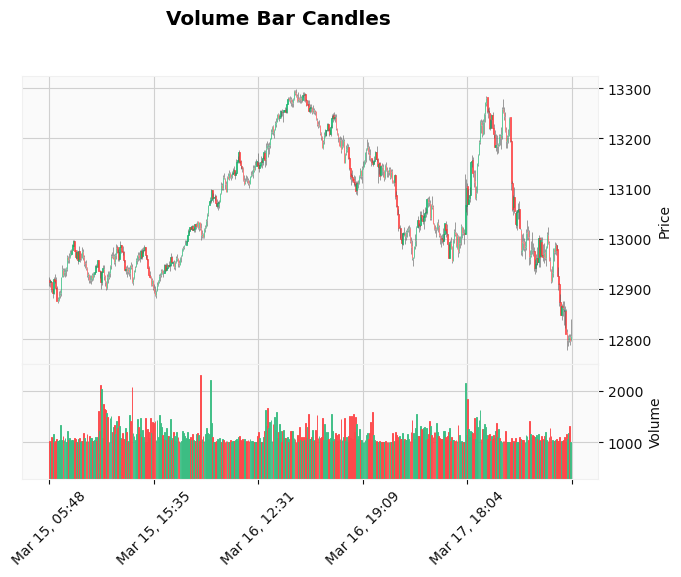

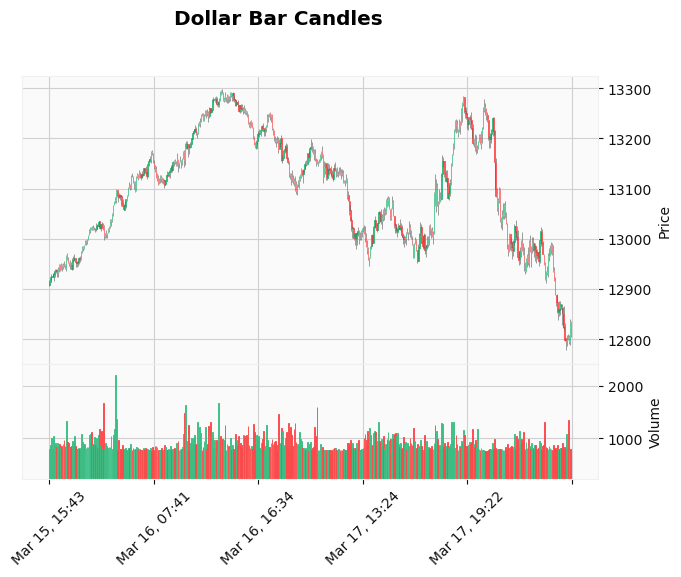

In [40]:
plot_candles(df_volumn_bars, title='Volume Bar Candles')
plot_candles(df_dollars_bars, title='Dollar Bar Candles')
